# Notes

This was a problem with Monaco's data

It was fixed by changing the cosmic ray rejection method

In [1]:
import os

print(os.listdir('./'))

['DataReductionProblem.ipynb', 'cfzst_0302_S175red_bis_24-02-2022.fits', '0302_S175red_bis_24-02-2022.fits', 'ecfzst_0302_S175red_bis_24-02-2022_395.fits', '.ipynb_checkpoints']


In [8]:
from ccdproc import CCDData
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval


def draw_plot(ccd):
    scale = ZScaleInterval()
    z1, z2 = scale.get_limits(ccd.data)
    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(ccd.data, clim=(z1, z2))

/usr/local/lib/python3.8/site-packages/astropy/wcs/wcs.py:707: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 59634.306323 from DATE-OBS'.
  warnings.warn(


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


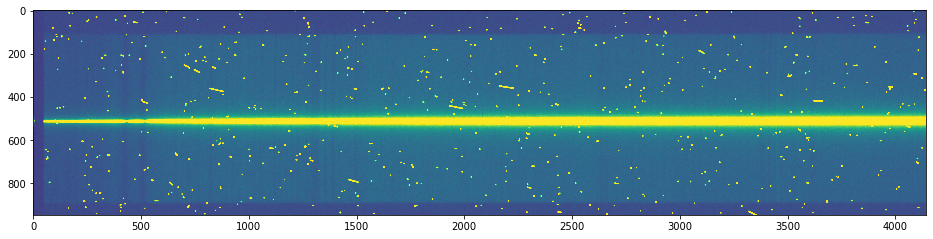

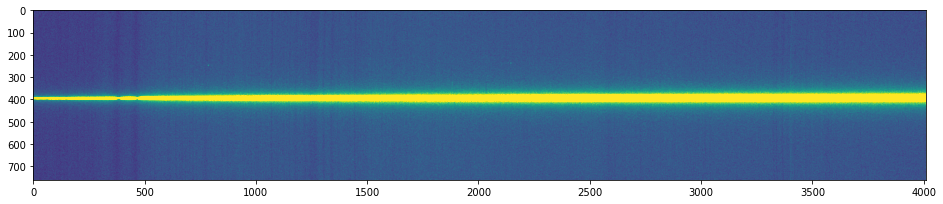

In [10]:
raw_ccd = CCDData.read('./0302_S175red_bis_24-02-2022.fits', unit='adu')
reduced_ccd = CCDData.read('./cfzst_0302_S175red_bis_24-02-2022.fits', unit='adu')

draw_plot(ccd=raw_ccd)
draw_plot(ccd=reduced_ccd)

In [25]:
from goodman_pipeline.core import identify_targets, trace_targets, extraction, setup_logging

log = setup_logging(debug=True, generic=True)

targets = identify_targets(ccd=reduced_ccd, fit_model='gaussian', background_threshold=2)

[18:52:14][    INFO]: Searching spectroscopic targets in file: cfzst_0302_S175red_bis_24-02-2022.fits [core.__call__:4245]
[18:52:14][   DEBUG]: Slit size: 0.45 [core.__call__:4255]
[18:52:14][   DEBUG]: Serial binning: 1 [core.__call__:4257]
[18:52:14][    INFO]: Fitting Linear1D model to spatial profile to detect background shape [core.fit_background:4322]
[18:52:14][    INFO]: Subtracting background shape and level spatial profile for better target identification [core.subtract_background:4403]
[18:52:14][   DEBUG]: New background level after subtraction was found to be 12.59 [core.subtract_background:4424]
[18:52:14][    INFO]: Finding all peaks in spatial profile [core.get_peaks:4484]
[18:52:14][   DEBUG]: Found 1 peaks [core.get_peaks:4502]
[18:52:14][    INFO]: Selecting the 3 most intense peaks out of 1 found [core.filter_peaks:4569]
[18:52:14][    INFO]: Validating peaks by setting threshold 2 times the background level 30.33 [core.filter_peaks:4581]
[18:52:14][   DEBUG]: Inte

In [26]:
print(targets)

[<Gaussian1D(amplitude=985.49918421, mean=394.00679476, stddev=1.7849151, name='Gaussian_394')>]


In [27]:
traces = trace_targets(ccd=reduced_ccd, target_list=targets)
print(traces)

/usr/local/lib/python3.8/site-packages/astropy/modeling/fitting.py:1718: AstropyUserWarning: Model is linear in parameters; consider using linear fitting methods.
  warnings.warn('Model is linear in parameters; '
[18:52:20][   DEBUG]: RMS Error of unclipped trace differences 0.347 [core.trace:3066]
[18:52:20][   DEBUG]: Re-fitting the trace for a better trace. [core.trace:3084]
/usr/local/lib/python3.8/site-packages/astropy/modeling/fitting.py:1718: AstropyUserWarning: Model is linear in parameters; consider using linear fitting methods.
  warnings.warn('Model is linear in parameters; '
[18:52:20][   DEBUG]: RMS Error after sigma-clipping trace differences 0.208 [core.trace:3097]
[18:52:20][    INFO]: Target tracing RMS error: 0.208 [core.trace:3116]
[18:52:20][   DEBUG]: Adding trace to list [core.trace_targets:3223]


[[<Polynomial1D(2, c0=395.19713531, c1=-0.00040656, c2=-0.00000005)>, <Gaussian1D(amplitude=985.49918421, mean=394.00679476, stddev=1.7849151, name='Gaussian_394')>, OrderedDict([('GSP_TMOD', ['Polynomial1D', 'Model name used to fit trace']), ('GSP_TORD', [2, 'Degree of the model used to fit target trace']), ('GSP_TC00', [395.19713531355774, 'Parameter c0']), ('GSP_TC01', [-0.0004065616676265953, 'Parameter c1']), ('GSP_TC02', [-5.025973806737457e-08, 'Parameter c2']), ('GSP_TERR', [0.207888485458018, 'RMS error of target trace'])])]]


In [28]:
for trace, profile, info in traces:
    print(trace, profile, info)
    extracted = extraction(ccd=reduced_ccd, target_trace=trace, spatial_profile=profile, extraction_name='fractional')

[18:52:26][    INFO]: Fractional Pixel Extraction for cfzst_0302_S175red_bis_24-02-2022.fits [core.extract_fractional_pixel:1171]
[18:52:26][    INFO]: Extraction aperture in first column: 390.99:399.40 [core.extract_fractional_pixel:1214]


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                   c1                     c2          
    ------------------ ---------------------- ----------------------
    395.19713531355774 -0.0004065616676265953 -5.025973806737457e-08 Model: Gaussian1D
Name: Gaussian_394
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev      
    ----------------- ----------------- ------------------
    985.4991842078178 394.0067947629072 1.7849151049947984 OrderedDict([('GSP_TMOD', ['Polynomial1D', 'Model name used to fit trace']), ('GSP_TORD', [2, 'Degree of the model used to fit target trace']), ('GSP_TC00', [395.19713531355774, 'Parameter c0']), ('GSP_TC01', [-0.0004065616676265953, 'Parameter c1']), ('GSP_TC02', [-5.025973806737457e-08, 'Parameter c2']), ('GSP_TERR', [0.207888485458018, 'RMS error of target trace'])])


[18:52:26][    INFO]: Background extraction zone 1: 369.98:378.38 column 1 [core.extraction:1133]
[18:52:26][    INFO]: Background extraction zone 2: 412.01:420.42 column 1 [core.extraction:1139]


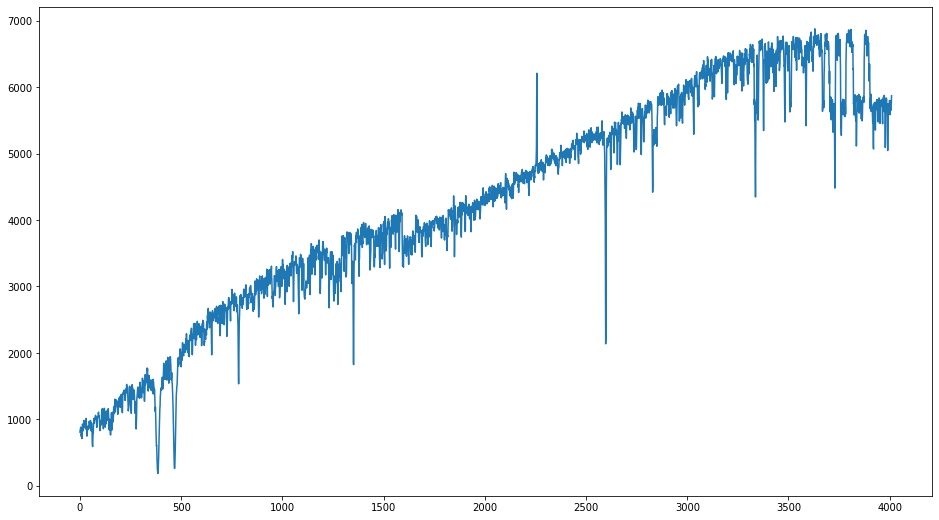

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(extracted.data)

In [56]:
import numpy as np

def quick_extraction(ccd, center, half_width):
    x, y = ccd.data.shape
    y_min = np.max([0, center - half_width])
    y_max = np.min([center + half_width, y])
    print(x, y, y_min, y_max)
    subsection = ccd.data[y_min:y_max,]
    new_data = np.sum(subsection, axis=0)
    fig, ax = plt.subplots(figsize=(16, 9))
    print(subsection.shape)
    ax.plot(new_data)
    
    

    

948 4142 509 519
(10, 4142)


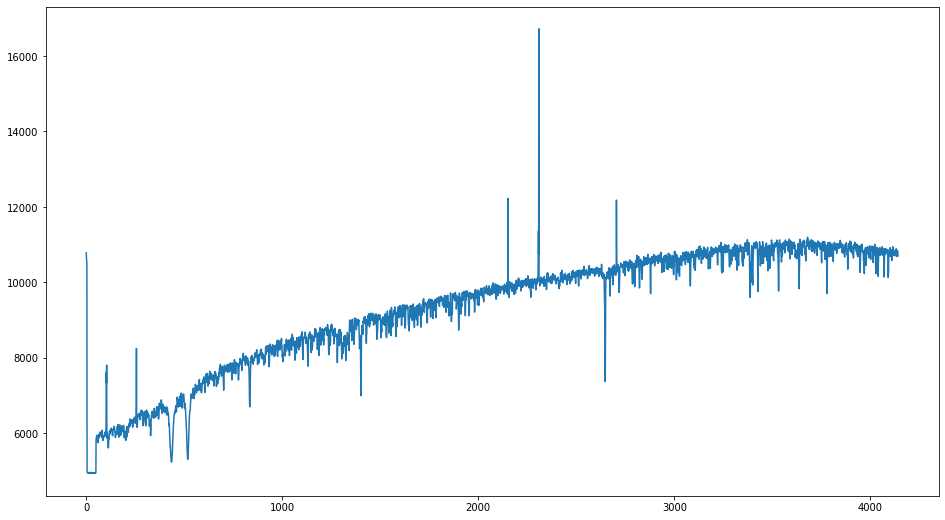

In [57]:
quick_extraction(ccd=raw_ccd, center=514, half_width=5)